In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

In [3]:
df=pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\(OIL) Oil Trading & Weather Dispersion\Price prediction\Data.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df['WTI'] = pd.to_numeric(df['WTI'])
df = df.sort_values(by='DATE', ascending=True)
df = df.set_index('DATE')
df = df.drop(columns=['Dubai','UK','Dubai Price', 'Brent'])
df = df.asfreq(pd.infer_freq(df.index))
df = df.resample('W').mean()
df = df.dropna()
df

,Texas,WTI
DATE,,
2020-07-12,26.875,40.4250
2020-07-19,28.960,40.5700
2020-07-26,26.940,41.3380
2020-08-02,27.340,40.6860
2020-08-09,29.400,41.1600
...,...,...
2024-08-11,27.650,75.8450
2024-08-18,29.500,78.9975
2024-08-25,30.100,74.6780


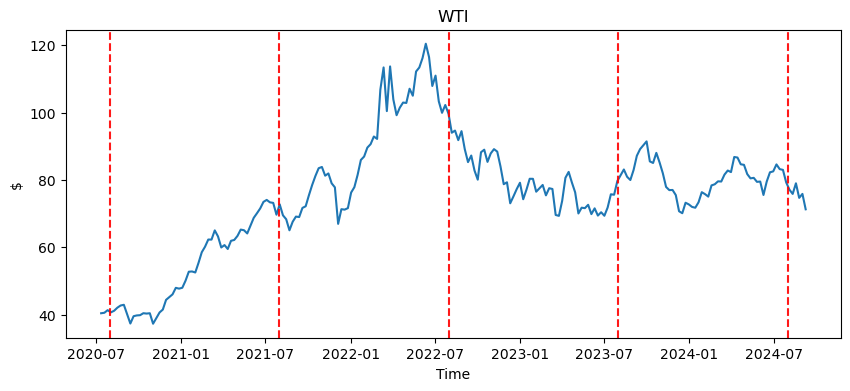

In [4]:
plt.figure(figsize=(10,4))
plt.plot(df['WTI'])
plt.title('WTI')
plt.xlabel('Time')
plt.ylabel('$')
for year in range(2020,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-31'),color='r',linestyle='--',alpha=0.9)

In [5]:
result = adfuller(df['WTI'])
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.17


In [6]:
first_diff = df['WTI'].diff()
first_diff = first_diff.dropna()
first_diff

DATE
2020-07-19    0.1450
2020-07-26    0.7680
2020-08-02   -0.6520
2020-08-09    0.4740
2020-08-16    0.9160
               ...  
2024-08-11   -1.2610
2024-08-18    3.1525
2024-08-25   -4.3195
2024-09-01    1.1745
2024-09-08   -4.5725
Name: WTI, Length: 215, dtype: float64

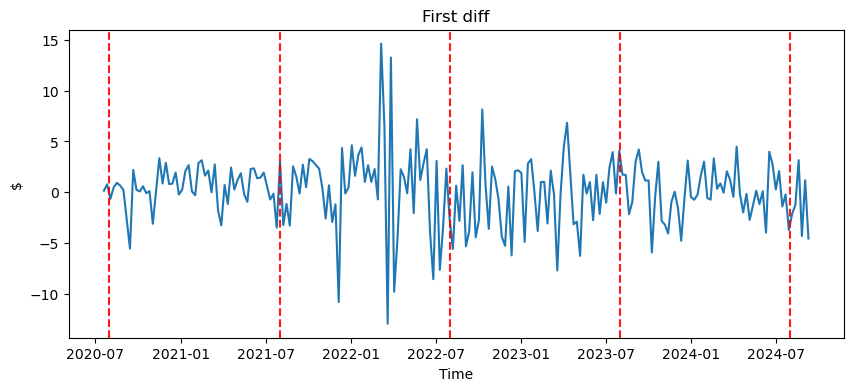

In [19]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First diff')
plt.xlabel('Time')
plt.ylabel('$')
for year in range(2020,2025):
    plt.axvline(pd.to_datetime(str(year)+'-07-31'),color='r',linestyle='--',alpha=0.9)

In [8]:
result = adfuller(first_diff)
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


In [9]:
print(len(first_diff))

215


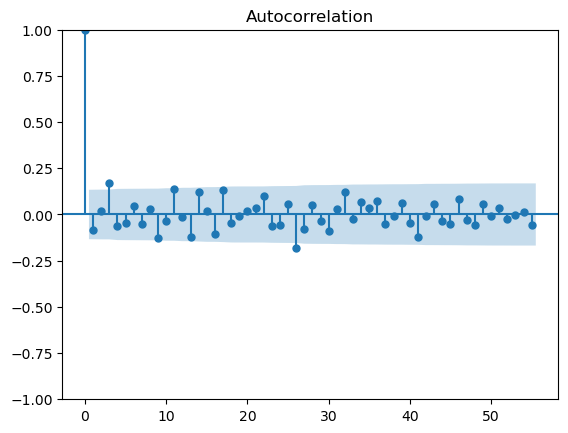

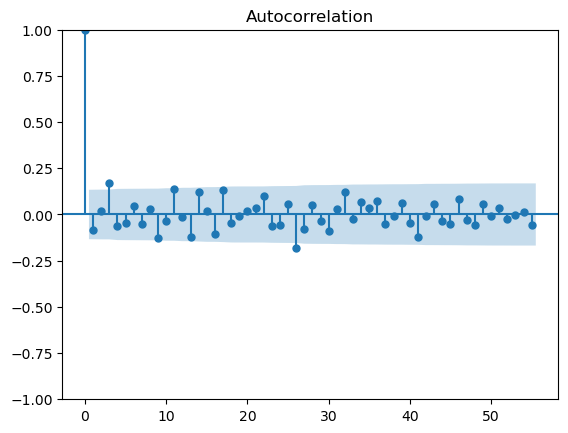

In [10]:
plot_acf(first_diff, lags=55)

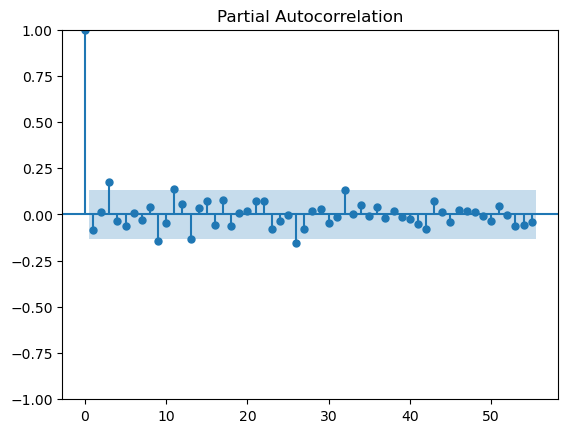

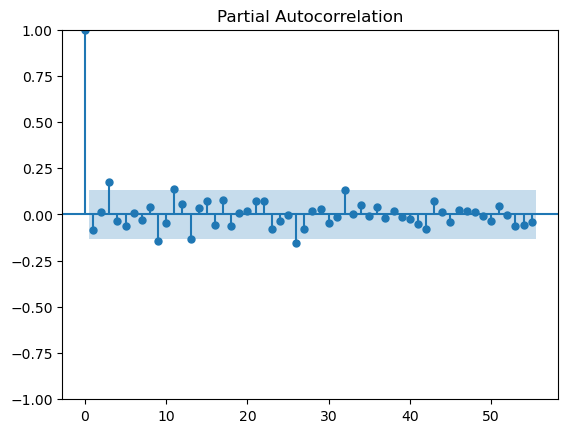

In [11]:
plot_pacf(first_diff, lags=55)

In [12]:
train_end = datetime(2024,5,31)
train_data_Texas = df['Texas'][:train_end]
train_data_WTI = df['WTI'][:train_end]
test_data_WTI = df['WTI'][train_end + timedelta(days=1):]
test_data_WTI

DATE
2024-06-02    79.5175
2024-06-09    75.5320
2024-06-16    79.5100
2024-06-23    82.2625
2024-06-30    82.5320
2024-07-07    84.6050
2024-07-14    83.2050
2024-07-21    82.9800
2024-07-28    79.2560
2024-08-04    77.1060
2024-08-11    75.8450
2024-08-18    78.9975
2024-08-25    74.6780
2024-09-01    75.8525
2024-09-08    71.2800
Name: WTI, dtype: float64

In [13]:
model = ARIMA(endog = train_data_WTI, exog = train_data_Texas, order = (3,1,3))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    WTI   No. Observations:                  201
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -521.628
Date:                Sun, 22 Sep 2024   AIC                           1059.256
Time:                        16:51:04   BIC                           1085.642
Sample:                             0   HQIC                          1069.934
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Texas         -0.0092      0.033     -0.279      0.780      -0.074       0.055
ar.L1         -0.4830      0.538     -0.898      0.369      -1.537       0.571
ar.L2         -0.7463      0.103     -7.232      0.0

In [14]:
rolling_predictions=pd.Series(index=test_data_WTI.index)

for i in test_data_WTI.index:
    train_data_WTI = df['WTI'][:i-timedelta(days=1)] #slicing when dealing with datetime is inclusive man so minus one day
    train_data_Texas = df['Texas'][:i-timedelta(days=1)] #slicing when dealing with datetime is inclusive man so minus one day
    test_data_Texas = df['Texas'][i]
    model = ARIMA(endog = train_data_WTI, exog = train_data_Texas, order = (3,1,3))
    model_fit = model.fit()
    prediction = model_fit.forecast(steps=1, exog = test_data_Texas)
    rolling_predictions.loc[i] = prediction.item()
rolling_predictions

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


DATE
2024-06-02    80.004859
2024-06-09    80.731683
2024-06-16    75.354615
2024-06-23    77.923495
2024-06-30    81.770145
2024-07-07    84.590767
2024-07-14    85.054771
2024-07-21    81.938785
2024-07-28    82.391263
2024-08-04    80.301194
2024-08-11    77.831926
2024-08-18    74.644305
2024-08-25    77.928710
2024-09-01    75.839664
2024-09-08    77.206137
dtype: float64

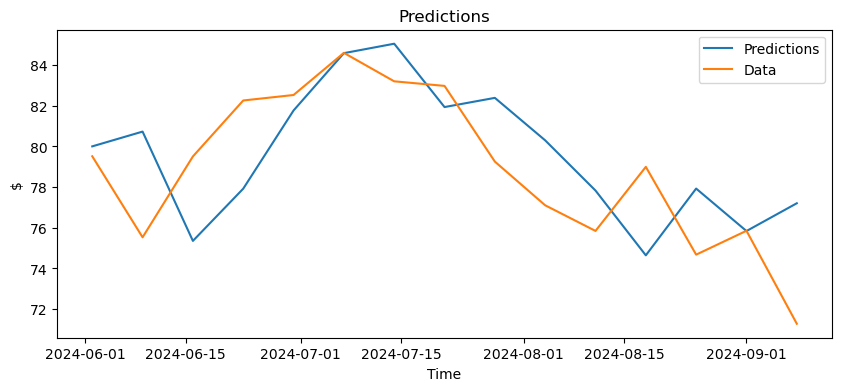

In [20]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, label='Predictions')
plt.plot(test_data_WTI, label='Data')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('$')
plt.legend()

Text(0, 0.5, '$')

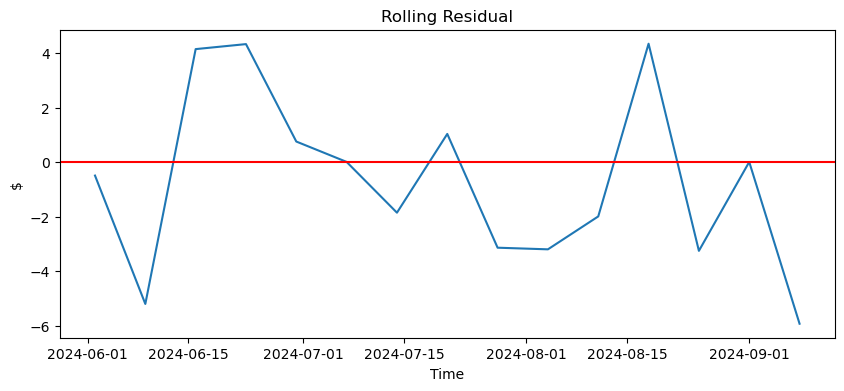

In [21]:
rolling_residual = test_data_WTI - rolling_predictions

plt.figure(figsize=(10,4))
plt.plot(rolling_residual)
plt.axhline(y=0, color = 'r')
plt.title('Rolling Residual')
plt.xlabel('Time')
plt.ylabel('$')

In [17]:
print('Mean abs % error:',np.mean(abs(rolling_residual/test_data_WTI)))

Mean abs % error: 0.03421964343844099


In [18]:
print('Root mean squared error (degrees):',np.sqrt(np.mean(rolling_residual**2)))

Root mean squared error (degrees): 3.2360318384754345
